### Federated Learning of the simple CNN model as **FL-CovidVGG16** using fedAvg

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-06-03 12:17:32.897926: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 12:17:32.965969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 12:17:32.966018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 12:17:32.966051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 12:17:32.977773: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
import pandas as pd
import random
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')
from sklearn import preprocessing

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from tqdm.notebook import tqdm
import time

#import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
import time
import numpy as np
IMAGE_SIZE = 200

### Functions to Evaluate Models after Training

In [ ]:
import seaborn as sns
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'

def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()

    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__,
                    predicted_labels=predictions)

## Data Source

Hopital 1 (Datasets 1), Hospital 2 (Dataset2 2) and Hospital 3 (Datasets 3)

- https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images (dataset3)
- https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/ (dataset3)

- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Dataset1)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Dataset1)

####  Loading NumPy Array Datasets:

In [ ]:
# # # Load the array from the file
input_data_x_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_input.npy')
output_label_y_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_output.npy')
input_data_x_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_input.npy')
output_label_y_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_output.npy')
input_data_x_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_input.npy')#.astype('float64')
output_label_y_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_output.npy')
#input_data_x_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_input.npy')
#output_label_y_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_output.npy')

#Now loaded_arr contains the array loaded from the file
print('------------------ DATASET 1 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_load.shape))

print('------------------ DATASET 2 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_2_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_2_load.shape))

print('------------------ DATASET 3 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_3_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_3_load.shape))

# print('------------------ DATASET 4 ---------------------')
# print('Input_x Data Shape: \n{0}'.format(input_data_x_4_load.shape))
# print('Output_y Data Shape: \n{0}'.format(output_label_y_4_load.shape))

------------------ DATASET 1 ---------------------
Input_x Data Shape: 
(4649, 200, 200, 1)
Output_y Data Shape: 
(4649, 2)
------------------ DATASET 2 ---------------------
Input_x Data Shape: 
(14486, 200, 200, 1)
Output_y Data Shape: 
(14486, 2)
------------------ DATASET 3 ---------------------
Input_x Data Shape: 
(2540, 200, 200, 1)
Output_y Data Shape: 
(2540, 2)


##### Data used to train teacher models for each client

In [ ]:
from sklearn.model_selection import train_test_split


train_features_dataset1, test_features_dataset1, train_labels_dataset1, test_labels_dataset1 = train_test_split(
    input_data_x_load[0:2500,:], output_label_y_load[0:2500,:], test_size=.20, random_state=25)

train_features_dataset2, test_features_dataset2, train_labels_dataset2, test_labels_dataset2 = train_test_split(
    input_data_x_2_load[0:6500,:], output_label_y_2_load[0:6500,:], test_size=.20, random_state=25)

train_features_dataset3, test_features_dataset3, train_labels_dataset3, test_labels_dataset3 = train_test_split(
    input_data_x_3_load[0:1200,:], output_label_y_3_load[0:1200,:], test_size=.20, random_state=25)

print('------ Training Teacher Models----------')
print('client 1 teacher dataset: ',train_features_dataset1.shape, test_features_dataset1.shape, train_labels_dataset1.shape, test_labels_dataset1.shape)
print('client 2 teacher dataset: ',train_features_dataset2.shape, test_features_dataset2.shape, train_labels_dataset2.shape, test_labels_dataset2.shape)
print('client 3 teacher dataset: ',train_features_dataset3.shape, test_features_dataset3.shape, train_labels_dataset3.shape, test_labels_dataset3.shape)

------ Training Teacher Models----------
client 1 teacher dataset:  (2000, 200, 200, 1) (500, 200, 200, 1) (2000, 2) (500, 2)
client 2 teacher dataset:  (5200, 200, 200, 1) (1300, 200, 200, 1) (5200, 2) (1300, 2)
client 3 teacher dataset:  (960, 200, 200, 1) (240, 200, 200, 1) (960, 2) (240, 2)


## Federated Learning Datasets

In [ ]:
def dataset_pixel_stat(dataset):
    mean_pixel_value = np.mean(dataset)
    variance_pixel_value = np.var(dataset)
    std_dev_pixel_value = np.std(dataset)
    # Display the computed statistics
    print("Mean Pixel Value:", mean_pixel_value)
    print("Variance of Pixel Values:", variance_pixel_value)
    print("Standard Deviation of Pixel Values:", std_dev_pixel_value)

    # Compute histograms of pixel values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Values (Entire Dataset)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Assuming you have subsets 'subset1' and 'subset2' of the dataset
    # Compute histograms for each subset
    plt.subplot(1, 2, 2)
    plt.hist(dataset[0:500,:].flatten(), bins=50, color='red', alpha=0.7, label='Subset 1')
    plt.hist(dataset[501:1000,:].flatten(), bins=50, color='green', alpha=0.7, label='Subset 2')
    plt.hist(dataset[1001:1500,:].flatten(), bins=50, color='yellow', alpha=0.7, label='Subset 3')

    plt.title('Histogram of Pixel Values (Subsets)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

In [ ]:
print('------ Federated Training----------')
train_features_dataset1_fed, test_features_dataset1_fed, train_labels_dataset1_fed, test_labels_dataset1_fed = train_test_split(
    input_data_x_load[2501:3901,:], output_label_y_load[2501:3901,:], test_size=.20, random_state=25)
train_features_dataset2_fed, test_features_dataset2_fed, train_labels_dataset2_fed, test_labels_dataset2_fed = train_test_split(
    input_data_x_2_load[6501:10400,:], output_label_y_2_load[6501:10400,:], test_size=.20, random_state=25)
train_features_dataset3_fed, test_features_dataset3_fed, train_labels_dataset3_fed, test_labels_dataset3_fed = train_test_split(
    input_data_x_3_load[1201:,:], output_label_y_3_load[1201:,:], test_size=.20, random_state=25)
print('client 1 federated dataset: ', train_features_dataset1_fed.shape, test_features_dataset1_fed.shape, train_labels_dataset1_fed.shape, test_labels_dataset1_fed.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed.shape, test_features_dataset2_fed.shape, train_labels_dataset2_fed.shape, test_labels_dataset2_fed.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed.shape, test_features_dataset3_fed.shape, train_labels_dataset3_fed.shape, test_labels_dataset3_fed.shape)


------ Federated Training----------
client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


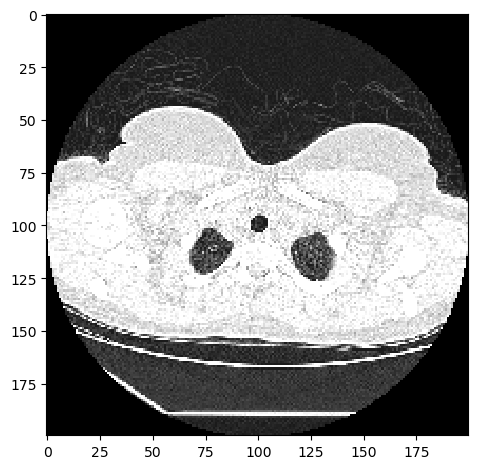

---------------Client 2 sample Image -----------------


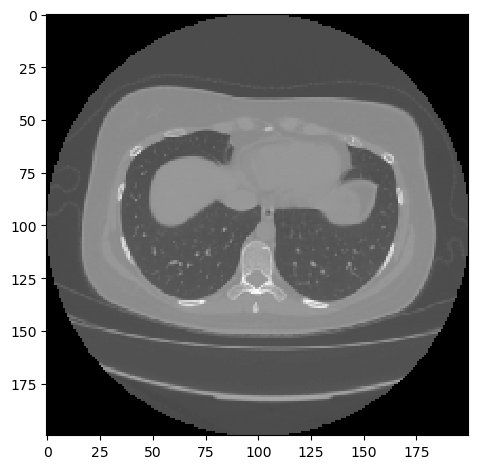

---------------Client 3 sample Image -----------------


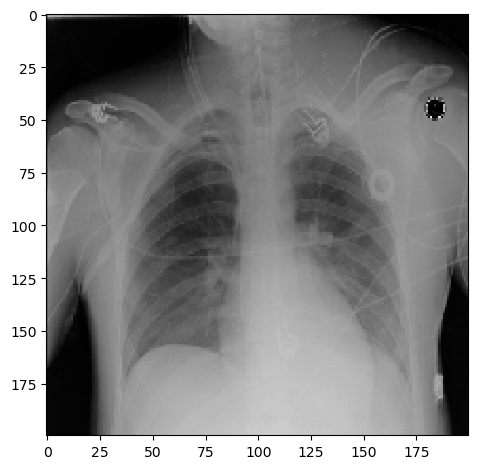

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed[0])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed[100])
show()

In [ ]:
print('--------------------- Testing dataset--------------')
# Assuming client_images and client_labels are numpy arrays or lists of numpy arrays
X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
                                  test_features_dataset3_fed), axis=0)
y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
                                  test_labels_dataset3_fed), axis=0)

--------------------- Testing dataset--------------


### Preparing The Federated Dataset (non_iid Dataset )

Mean Pixel Value: 0.5149437324054628
Variance of Pixel Values: 0.13384306055452233
Standard Deviation of Pixel Values: 0.36584567860577816


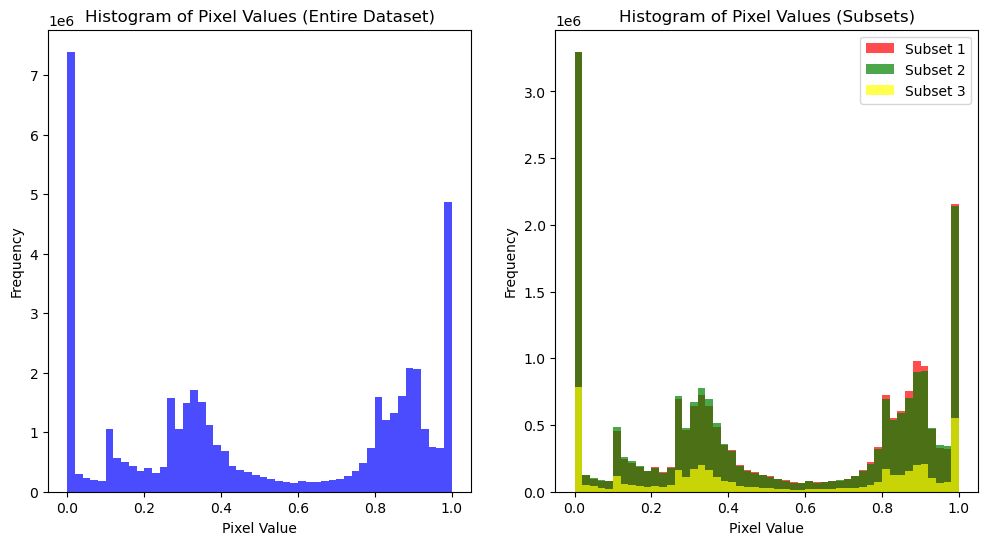

Mean Pixel Value: 0.2761424951121855
Variance of Pixel Values: 0.056925370933381306
Standard Deviation of Pixel Values: 0.23859038315359926


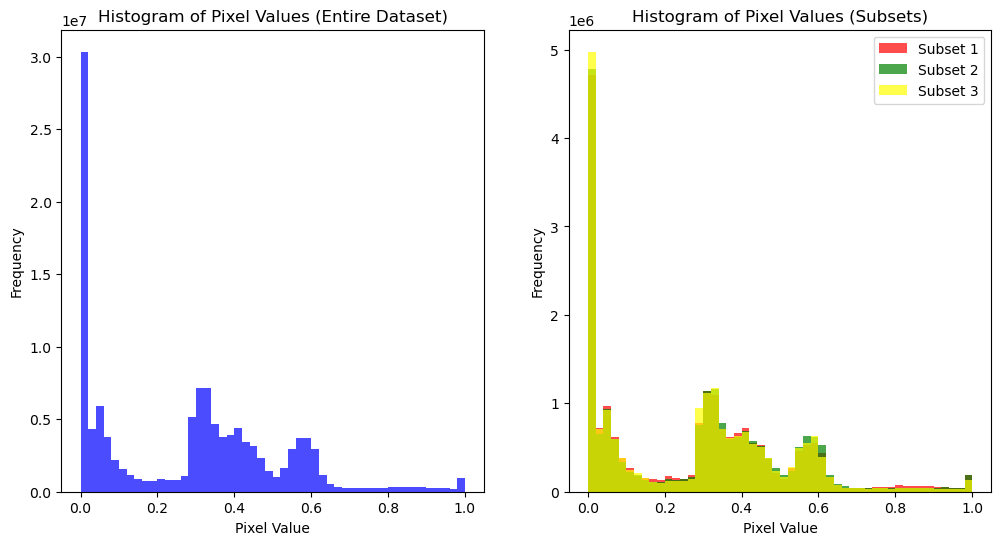

Mean Pixel Value: 0.5393774509803901
Variance of Pixel Values: 0.07674632723644069
Standard Deviation of Pixel Values: 0.2770312748345224


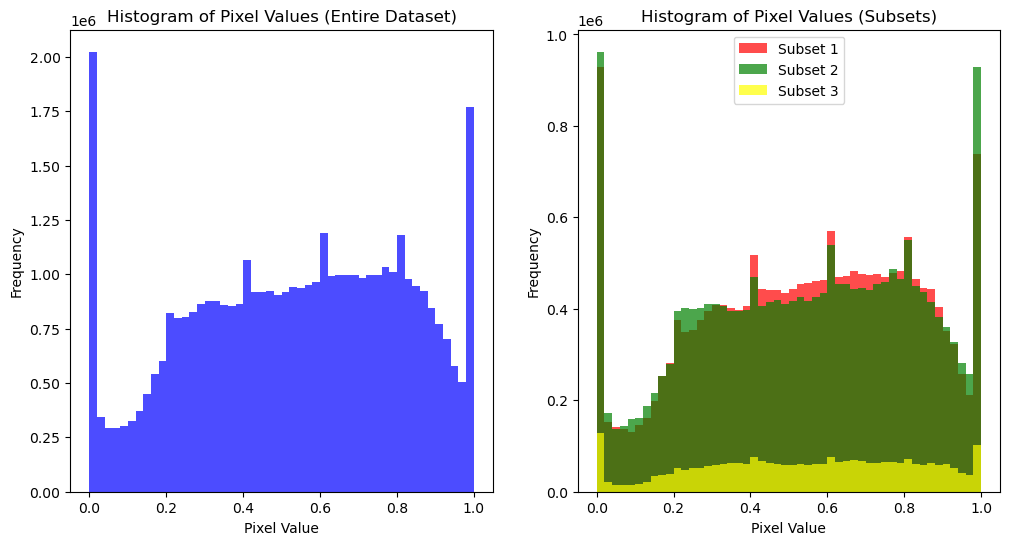

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed)
dataset_pixel_stat(train_features_dataset2_fed)
dataset_pixel_stat(train_features_dataset3_fed)

###### non-iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed, train_labels_dataset2_fed),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]#(train_features_dataset3_fed, train_labels_dataset3_fed)

NUM_CLIENTS = len(client_data)  # Number of clients
BATCH_SIZE = 20

def create_tf_dataset_for_client(client_dataset):
    """Create a tf.data.Dataset object for a client's data."""
    client_images, client_labels = client_dataset
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    return dataset

client_datasets = [create_tf_dataset_for_client(data) for data in client_data]

def preprocess_dataset(dataset, batch_size=BATCH_SIZE , shuffle_buffer_size=100):
    """Preprocess the dataset."""
    return dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#federated_clients
fed_clients = ['client_'+str(i) for i in range(1,NUM_CLIENTS+1)]

# Federated data preparation
federated_train_data_nonIID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid Unbalanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid Unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### non-iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed[0:1200,:], train_labels_dataset2_fed[0:1200,:]),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_nonIID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid balanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Preparing The Federated Dataset (iid Dataset )

In [ ]:
train_features_dataset1_fed_iid, test_features_dataset1_fed_iid, train_labels_dataset1_fed_iid, test_labels_dataset1_fed_iid = train_test_split(
    input_data_x_2_load[6501:7901,:], output_label_y_2_load[6501:7901,:], test_size=.20, random_state=42)
train_features_dataset2_fed_iid, test_features_dataset2_fed_iid, train_labels_dataset2_fed_iid, test_labels_dataset2_fed_iid = train_test_split(
    input_data_x_2_load[7901:11800,:], output_label_y_2_load[7901:11800,:], test_size=.20, random_state=42)
train_features_dataset3_fed_iid, test_features_dataset3_fed_iid, train_labels_dataset3_fed_iid, test_labels_dataset3_fed_iid = train_test_split(
    input_data_x_2_load[11800:13139,:], output_label_y_2_load[11800:13139,:], test_size=.20, random_state=42)
print('client 1 federated dataset: ', train_features_dataset1_fed_iid.shape, test_features_dataset1_fed_iid.shape, train_labels_dataset1_fed_iid.shape, test_labels_dataset1_fed_iid.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed_iid.shape, test_features_dataset2_fed_iid.shape, train_labels_dataset2_fed_iid.shape, test_labels_dataset2_fed_iid.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed_iid.shape, test_features_dataset3_fed_iid.shape, train_labels_dataset3_fed_iid.shape, test_labels_dataset3_fed_iid.shape)

client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


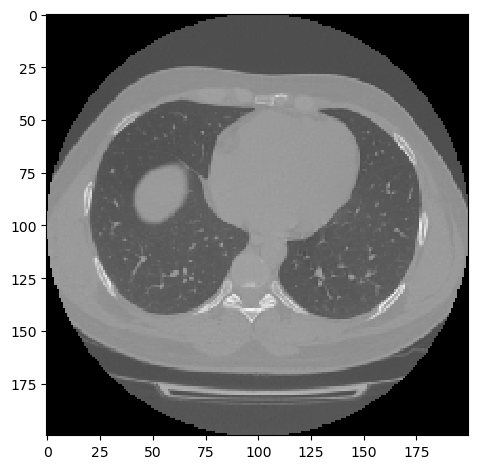

---------------Client 2 sample Image -----------------


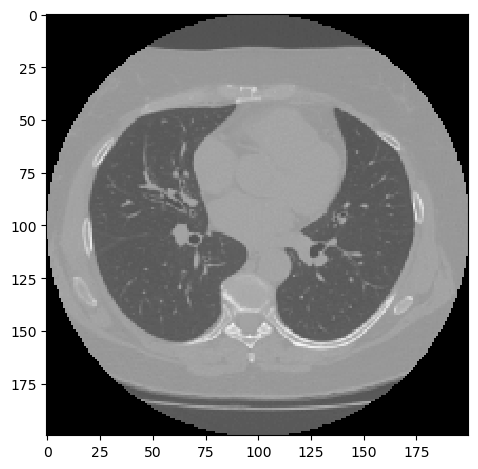

---------------Client 3 sample Image -----------------


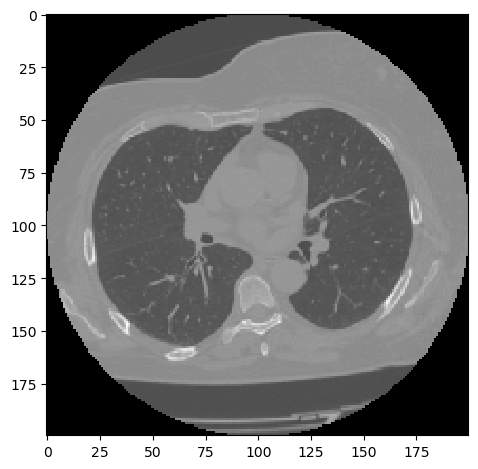

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed_iid[100])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed_iid[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed_iid[0])
show()

Mean Pixel Value: 0.27787371095938374
Variance of Pixel Values: 0.0582723553891214
Standard Deviation of Pixel Values: 0.24139667642517657


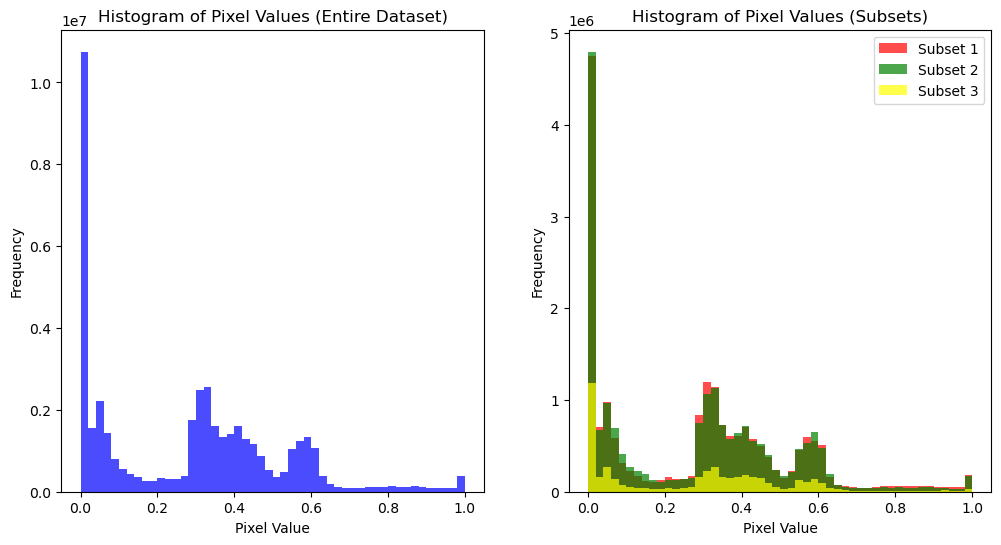

Mean Pixel Value: 0.27760929562014075
Variance of Pixel Values: 0.056485812467578035
Standard Deviation of Pixel Values: 0.2376674409076221


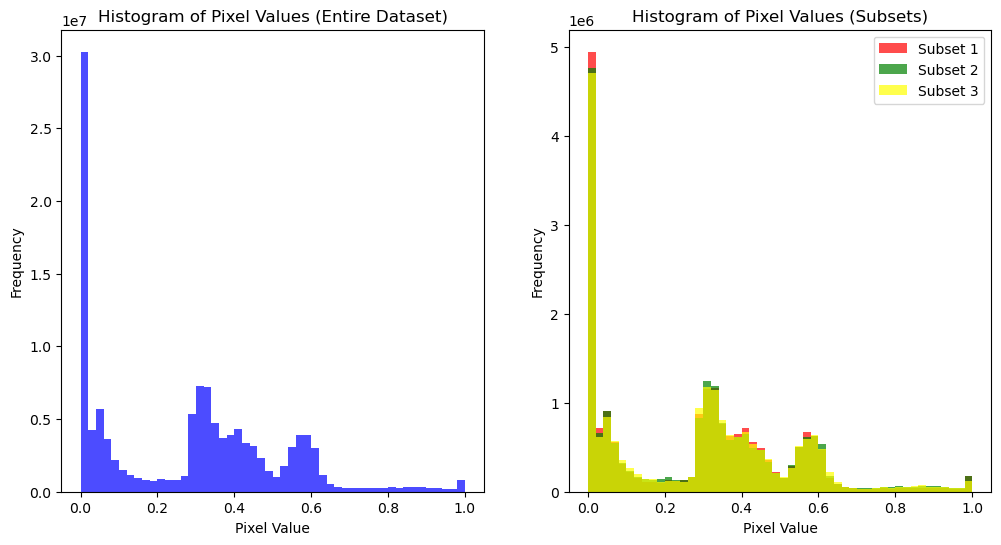

Mean Pixel Value: 0.2768275683345227
Variance of Pixel Values: 0.05673954491991269
Standard Deviation of Pixel Values: 0.23820064004933464


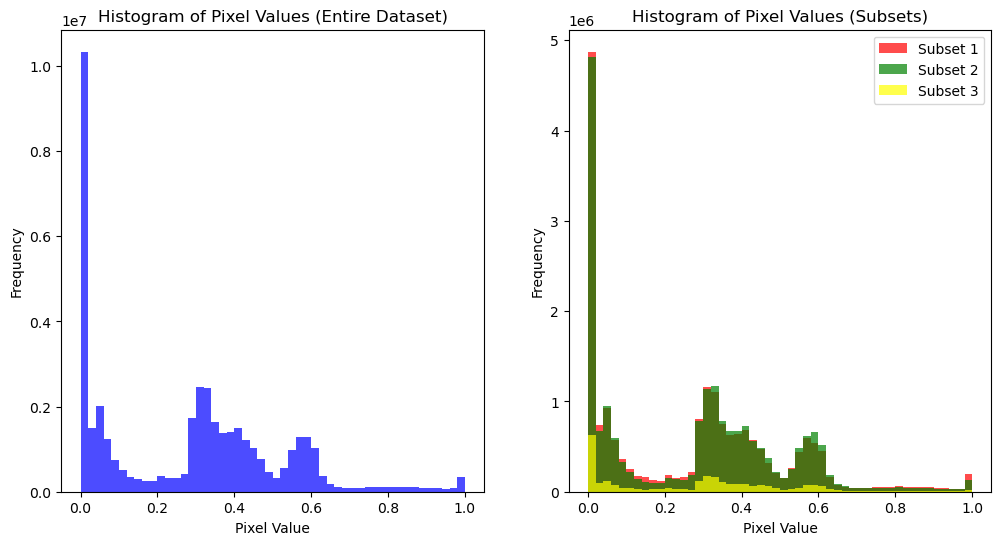

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed_iid)
dataset_pixel_stat(train_features_dataset2_fed_iid)
dataset_pixel_stat(train_features_dataset3_fed_iid)

###### iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid, train_labels_dataset2_fed_iid),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid unbalanced Dataset Data type: ', type(federated_train_data_IID_unbalanced))
print('Length: ', len(federated_train_data_IID_unbalanced))

Fedrated iid unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid[0:1200,:], train_labels_dataset2_fed_iid[0:1200,:]),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid balanced Dataset Data type: ', type(federated_train_data_IID_balanced))
print('Length: ', len(federated_train_data_IID_balanced))

Fedrated iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Federated Learning

In [ ]:

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications import VGG16
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)
input_tensor = Input(shape=input_shape)
input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)

#CovidVGG16 Architecture
def create_CovidVGG16_model(num_hl, hl_list, hl_conv_activation, ol_activation, dropout_val, inputShape, filters_, kernel_size_, stride_poolSize):
    '''
    CNN_Mod(num_hl, hl_list, hl_conv_activation, ol_activation, dropout_val, inputShape, filters_, kernel_size_, stride_poolSize):
        num_hl = number of hidden layers
        hl_list = list of hidden layer units
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert num_hl == len(hl_list)
    assert num_hl == len(dropout_val)
    input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
    input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)
    inputs = tf.keras.layers.Input(shape=inputShape)
    # Augment data.
    image_size_ = 200


    # Load EfficientNet as base model
    base_model = VGG16(include_top=False, input_tensor=input_rgb, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add custom head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    for i in range(num_hl):
        x = tf.keras.layers.Dense(units=hl_list[i], activation=hl_conv_activation)(x)
        x = tf.keras.layers.Dropout(dropout_val[i])(x)

    # Output layer
    logits = tf.keras.layers.Dense(units=2, activation=ol_activation)(x)

    # Create the Keras model
    model = tf.keras.Model(inputs=base_model.input, outputs=logits)


    return model

#CNN_Mod_VGG16 Teacher Model wrapping as TFF model
def model_fn(initial_weights=None):
    keras_model = create_CovidVGG16_model(4, [2756, 1776, 620, 152],'relu','softmax',[0.15,0.00,0.00,0.15],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    """Performs local training on the client's dataset."""
    # Initialize the client model with the current server weights.
    client_weights = model.trainable_variables
    # Assign the server weights to the client model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)
    # Initialize the client optimizer.
    trainable_tensor_specs = tf.nest.map_structure(
          lambda v: tf.TensorSpec(v.shape, v.dtype), client_weights)
    optimizer_state = client_optimizer.initialize(trainable_tensor_specs)
    # Use the client_optimizer to update the local model.
    for batch in iter(dataset):
        with tf.GradientTape() as tape:
            # Compute a forward pass on the batch of data.
            outputs = model.forward_pass(batch)
        # Compute the corresponding gradient.
        grads = tape.gradient(outputs.loss, client_weights)
        # Apply the gradient using a client optimizer.
        optimizer_state, updated_weights = client_optimizer.next(
            optimizer_state, client_weights, grads)
        tf.nest.map_structure(lambda a, b: a.assign(b),
                              client_weights, updated_weights)
    # Return model deltas.
    return tf.nest.map_structure(tf.subtract, client_weights, server_weights)

In [ ]:
import attrs
from typing import Any
import functools
@attrs.define(eq=False, frozen=True)
class ServerState(object):
    trainable_weights: Any
    optimizer_state: Any

@tf.function
def server_update(server_state, mean_model_delta, server_optimizer):
    """Updates the server model weights."""
    # Use aggregated negative model delta as pseudo gradient.
    negative_weights_delta = tf.nest.map_structure(
      lambda w: -1.0 * w, mean_model_delta)
    new_optimizer_state, updated_weights = server_optimizer.next(
      server_state.optimizer_state, server_state.trainable_weights,
      negative_weights_delta)
    return tff.structure.update_struct(
      server_state,
      trainable_weights=updated_weights,
      optimizer_state=new_optimizer_state)

In [ ]:
#1. Server and client optimizer to be used.
server_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.05, momentum=0.8)
client_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.0001)


In [ ]:
# 2. Functions return initial state on server.
@tff.tf_computation
def server_init():
    model = model_fn()
    trainable_tensor_specs = tf.nest.map_structure(
        lambda v: tf.TensorSpec(v.shape, v.dtype), model.trainable_variables)
    optimizer_state = server_optimizer.initialize(trainable_tensor_specs)
    return ServerState(
      trainable_weights=model.trainable_variables,
      optimizer_state=optimizer_state)
@tff.federated_computation
def server_init_tff():
    return tff.federated_value(server_init(), tff.SERVER)

/tmp/ipykernel_16131/591050228.py:3: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  def server_init():
2024-06-04 00:17:29.991246: W tensorflow/c/c_api.cc:305] Operation '{name:'block4_conv3/bias/Assign' id:245 op device:{requested: '', assigned: ''} def:{{{node block4_conv3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block4_conv3/bias, block4_conv3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
# 3. One round of computation and communication.
server_state_type = server_init.type_signature.result
print('server_state_type:\n',
      server_state_type.formatted_representation())
trainable_weights_type = server_state_type.trainable_weights
print('trainable_weights_type:\n',
      trainable_weights_type.formatted_representation())

server_state_type:
 <
  trainable_weights=<
    float32[512,2756],
    float32[2756],
    float32[2756,1776],
    float32[1776],
    float32[1776,620],
    float32[620],
    float32[620,152],
    float32[152],
    float32[152,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[512,2756],
      float32[2756],
      float32[2756,1776],
      float32[1776],
      float32[1776,620],
      float32[620],
      float32[620,152],
      float32[152],
      float32[152,2],
      float32[2]
    >
  >
>
trainable_weights_type:
 <
  float32[512,2756],
  float32[2756],
  float32[2756,1776],
  float32[1776],
  float32[1776,620],
  float32[620],
  float32[620,152],
  float32[152],
  float32[152,2],
  float32[2]
>


In [ ]:
# 3-1. Wrap server and client TF blocks with `tff.tf_computation`.
@tff.tf_computation(server_state_type, trainable_weights_type)
def server_update_fn(server_state, model_delta):
    return server_update(server_state, model_delta, server_optimizer)

/tmp/ipykernel_16131/2044740559.py:2: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(server_state_type, trainable_weights_type)


In [ ]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(tff.types.tensorflow_to_type(whimsy_model.input_spec))
print('tf_dataset_type:\n',
      tf_dataset_type.formatted_representation())

@tff.tf_computation(tf_dataset_type, trainable_weights_type)
def client_update_fn(dataset, server_weights):
    model = model_fn()
    return client_update(model, dataset, server_weights, client_optimizer)

tf_dataset_type:
 <
  float64[?,200,200,1],
  uint8[?,2]
>*


/tmp/ipykernel_16131/3793503675.py:6: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(tf_dataset_type, trainable_weights_type)
2024-06-04 00:17:36.120529: W tensorflow/c/c_api.cc:305] Operation '{name:'block3_conv3/bias/Assign' id:183 op device:{requested: '', assigned: ''} def:{{{node block3_conv3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block3_conv3/bias, block3_conv3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
# 3-2. Orchestration with `tff.federated_computation`.
federated_server_type = tff.FederatedType(server_state_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
@tff.federated_computation(federated_server_type, federated_dataset_type)
def run_one_round(server_state, federated_dataset):
    # Server-to-client broadcast.
    server_weights_at_client = tff.federated_broadcast(
      server_state.trainable_weights)
    # Local client update.
    model_deltas = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
    # Client-to-server upload and aggregation.
    mean_model_delta = tff.federated_mean(model_deltas)
    # Server update.
    server_state = tff.federated_map(
      server_update_fn, (server_state, mean_model_delta))
    return server_state

In [ ]:
# 4. Build the iterative process for FedAvg.
fedavg_process = tff.templates.IterativeProcess(
    initialize_fn=server_init_tff, next_fn=run_one_round)
print('type signature of `initialize`:\n',
      fedavg_process.initialize.type_signature.formatted_representation())
print('type signature of `next`:\n',
      fedavg_process.next.type_signature.formatted_representation())

type signature of `initialize`:
 ( -> <
  trainable_weights=<
    float32[512,2756],
    float32[2756],
    float32[2756,1776],
    float32[1776],
    float32[1776,620],
    float32[620],
    float32[620,152],
    float32[152],
    float32[152,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[512,2756],
      float32[2756],
      float32[2756,1776],
      float32[1776],
      float32[1776,620],
      float32[620],
      float32[620,152],
      float32[152],
      float32[152,2],
      float32[2]
    >
  >
>@SERVER)
type signature of `next`:
 (<
  server_state=<
    trainable_weights=<
      float32[512,2756],
      float32[2756],
      float32[2756,1776],
      float32[1776],
      float32[1776,620],
      float32[620],
      float32[620,152],
      float32[152],
      float32[152,2],
      float32[2]
    >,
    optimizer_state=<
      learning_rate=float32,
      momentum=float32,
      accumulator=<
        fl

### Evaluating the algorithm

https://www.tensorflow.org/federated/tutorials/custom_federated_algorithm_with_tff_optimizers#evaluating_the_algorithm

In [ ]:
def map_function(input_data, target_data):
    # Apply any necessary transformations to input_data and target_data here
    # For example, you can cast the target_data to a different dtype if needed
    target_data = tf.cast(target_data, tf.float32)
    return input_data, target_data

test_data = [(X_test_combined,y_test_combined )]
test_datasets = [create_tf_dataset_for_client(data) for data in test_data]
combined_test_data = [preprocess_dataset(dataset) for dataset in test_datasets]
combined_test_data = combined_test_data[0].map(map_function)

In [ ]:
def evaluate(server_state, dataset):
    keras_model = create_CovidVGG16_model(4, [2756, 1776, 620, 152],'relu','softmax',[0.15,0.00,0.00,0.15],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
    #student_model = tf.keras.models.load_model('student_CNN_model.h5')
    #model_student_weight = student_model.get_weights()
    #keras_model.set_weights(model_student_weight)
    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    #keras_model.set_weights(server_state.trainable_weights)
    # Assign the new weights to the trainable variables
    for var, new_weight in zip(keras_model.trainable_variables, server_state.trainable_weights):
        var.assign(new_weight)
    keras_model.evaluate(dataset)
    return keras_model

server_state = fedavg_process.initialize()
student_inital_model = evaluate(server_state, combined_test_data)

2024-06-04 00:18:15.351354: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-04 00:18:15.351446: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-04 00:18:15.355157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14710 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-04 00:18:15.355366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14710 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-04 00:18:15.355564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14710 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 23s 341ms/step - loss: 0.6961 - categorical_accuracy: 0.4834


9/9 [==============================] - 5s 508ms/step


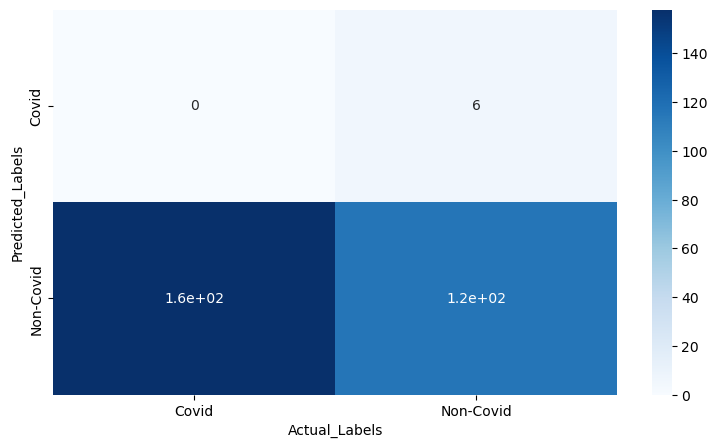

test accuracy = 41.42857142857143%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4143
Precision: 0.1845
Recall: 0.4143
F1 Score: 0.2553
25/25 [==============================] - 13s 502ms/step


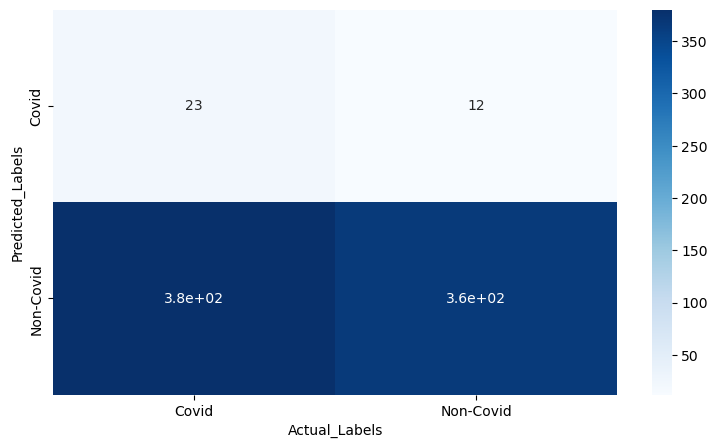

test accuracy = 49.743589743589745%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4974
Precision: 0.5763
Recall: 0.4974
F1 Score: 0.3687
9/9 [==============================] - 4s 482ms/step


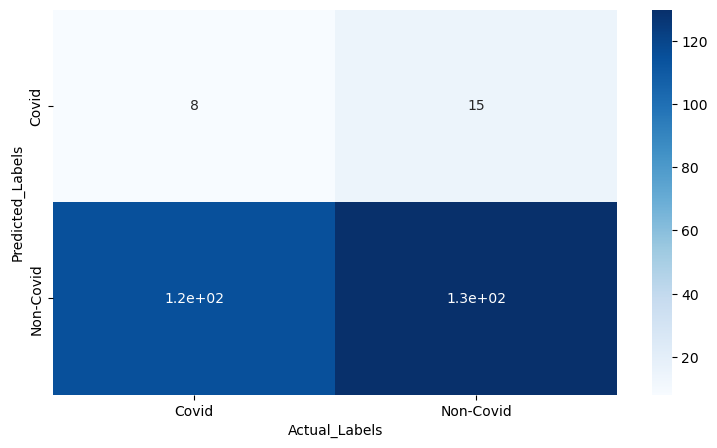

test accuracy = 51.49253731343284%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5149
Precision: 0.4467
Recall: 0.5149
F1 Score: 0.411


In [ ]:
# X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
#                                   test_features_dataset3_fed), axis=0)
# y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
#                                   test_labels_dataset3_fed), axis=0)
getModelEvaluation(student_inital_model,test_features_dataset1_fed,test_labels_dataset1_fed)
getModelEvaluation(student_inital_model,test_features_dataset2_fed,test_labels_dataset2_fed)
getModelEvaluation(student_inital_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
metrics = {'loss':[],'accuracy':[]}

## FedAvg StudentMod_only Experiments

- federated_train_data_nonIID_unbalanced
- federated_train_data_nonIID_balanced
- federated_train_data_IID_unbalanced
- federated_train_data_IID_balanced

### federated_train_data_nonIID_unbalanced

In [ ]:
from tqdm import tqdm
import time
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_unbalanced)
    FL_CovidVGG16_model = evaluate(server_state,combined_test_data)
    loss = list(FL_CovidVGG16_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidVGG16_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2024-06-04 00:20:05.202605: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-04 00:20:05.202684: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-04 00:20:05.206289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14710 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-04 00:20:05.206500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14710 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-04 00:20:05.206706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14710 MB m

67/67 [==============================] - 49s 721ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


  2%|▊                                        | 1/50 [04:19<3:31:44, 259.28s/it]

67/67 [==============================] - 57s 850ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


  4%|█▋                                       | 2/50 [08:01<3:10:04, 237.60s/it]

67/67 [==============================] - 43s 631ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


  6%|██▍                                      | 3/50 [12:51<3:24:49, 261.48s/it]

67/67 [==============================] - 43s 633ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


  8%|███▎                                     | 4/50 [17:14<3:20:45, 261.86s/it]

67/67 [==============================] - 57s 846ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 10%|████                                     | 5/50 [21:24<3:13:20, 257.79s/it]

67/67 [==============================] - 31s 456ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 12%|████▉                                    | 6/50 [24:51<2:56:19, 240.44s/it]

67/67 [==============================] - 43s 639ms/step - loss: 0.6961 - categorical_accuracy: 0.4804


 14%|█████▋                                   | 7/50 [29:56<3:07:30, 261.64s/it]

67/67 [==============================] - 46s 674ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 16%|██████▌                                  | 8/50 [34:18<3:03:11, 261.71s/it]

67/67 [==============================] - 56s 832ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 18%|███████▍                                 | 9/50 [38:31<2:56:54, 258.90s/it]

67/67 [==============================] - 33s 489ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 20%|████████                                | 10/50 [42:16<2:45:36, 248.42s/it]

67/67 [==============================] - 43s 630ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 22%|████████▊                               | 11/50 [46:39<2:44:23, 252.90s/it]

67/67 [==============================] - 57s 845ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 24%|█████████▌                              | 12/50 [50:59<2:41:34, 255.12s/it]

67/67 [==============================] - 24s 348ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 26%|██████████▍                             | 13/50 [54:30<2:29:00, 241.62s/it]

67/67 [==============================] - 42s 626ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 28%|███████████▏                            | 14/50 [58:53<2:29:01, 248.36s/it]

67/67 [==============================] - 23s 346ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 30%|███████████▍                          | 15/50 [1:01:24<2:07:43, 218.97s/it]

67/67 [==============================] - 43s 632ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 32%|████████████▏                         | 16/50 [1:05:49<2:11:57, 232.86s/it]

67/67 [==============================] - 24s 351ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 34%|████████████▉                         | 17/50 [1:08:18<1:54:11, 207.61s/it]

67/67 [==============================] - 43s 633ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 36%|█████████████▋                        | 18/50 [1:12:44<1:59:59, 224.99s/it]

67/67 [==============================] - 57s 847ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 38%|██████████████▍                       | 19/50 [1:16:44<1:58:40, 229.68s/it]

67/67 [==============================] - 25s 361ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 40%|███████████████▏                      | 20/50 [1:20:18<1:52:26, 224.87s/it]

67/67 [==============================] - 44s 629ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 42%|███████████████▉                      | 21/50 [1:25:23<2:00:22, 249.04s/it]

67/67 [==============================] - 50s 735ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 44%|████████████████▋                     | 22/50 [1:29:45<1:57:54, 252.66s/it]

67/67 [==============================] - 56s 829ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 46%|█████████████████▍                    | 23/50 [1:33:29<1:49:53, 244.21s/it]

67/67 [==============================] - 43s 631ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 48%|██████████████████▏                   | 24/50 [1:37:36<1:46:14, 245.15s/it]

67/67 [==============================] - 50s 739ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 50%|███████████████████                   | 25/50 [1:41:55<1:43:49, 249.18s/it]

67/67 [==============================] - 57s 835ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 52%|███████████████████▊                  | 26/50 [1:46:07<1:39:57, 249.91s/it]

67/67 [==============================] - 37s 547ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 54%|████████████████████▌                 | 27/50 [1:49:59<1:33:50, 244.79s/it]

67/67 [==============================] - 44s 640ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 56%|█████████████████████▎                | 28/50 [1:54:22<1:31:39, 249.99s/it]

67/67 [==============================] - 57s 840ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 58%|██████████████████████                | 29/50 [1:58:13<1:25:30, 244.33s/it]

67/67 [==============================] - 39s 579ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 60%|██████████████████████▊               | 30/50 [2:02:10<1:20:45, 242.26s/it]

67/67 [==============================] - 43s 638ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 62%|███████████████████████▌              | 31/50 [2:06:32<1:18:35, 248.20s/it]

67/67 [==============================] - 56s 830ms/step - loss: 0.6960 - categorical_accuracy: 0.4827


 64%|████████████████████████▎             | 32/50 [2:10:19<1:12:34, 241.90s/it]

67/67 [==============================] - 42s 622ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 66%|█████████████████████████             | 33/50 [2:15:01<1:11:54, 253.82s/it]

67/67 [==============================] - 42s 620ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 68%|█████████████████████████▊            | 34/50 [2:19:20<1:08:06, 255.42s/it]

67/67 [==============================] - 57s 841ms/step - loss: 0.6960 - categorical_accuracy: 0.4842


 70%|██████████████████████████▌           | 35/50 [2:24:01<1:05:47, 263.18s/it]

67/67 [==============================] - 57s 846ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 72%|███████████████████████████▎          | 36/50 [2:28:09<1:00:20, 258.58s/it]

67/67 [==============================] - 35s 508ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 74%|█████████████████████████████▌          | 37/50 [2:32:00<54:12, 250.23s/it]

67/67 [==============================] - 42s 628ms/step - loss: 0.6960 - categorical_accuracy: 0.4827


 76%|██████████████████████████████▍         | 38/50 [2:37:05<53:20, 266.67s/it]

67/67 [==============================] - 53s 784ms/step - loss: 0.6960 - categorical_accuracy: 0.4827


 78%|███████████████████████████████▏        | 39/50 [2:41:55<50:09, 273.59s/it]

67/67 [==============================] - 56s 834ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 80%|████████████████████████████████        | 40/50 [2:46:17<45:02, 270.23s/it]

67/67 [==============================] - 31s 461ms/step - loss: 0.6959 - categorical_accuracy: 0.4834


 82%|████████████████████████████████▊       | 41/50 [2:49:47<37:49, 252.20s/it]

67/67 [==============================] - 42s 622ms/step - loss: 0.6959 - categorical_accuracy: 0.4842


 84%|█████████████████████████████████▌      | 42/50 [2:54:50<35:39, 267.48s/it]

67/67 [==============================] - 45s 659ms/step - loss: 0.6959 - categorical_accuracy: 0.4842


 86%|██████████████████████████████████▍     | 43/50 [2:59:49<32:18, 276.93s/it]

67/67 [==============================] - 57s 836ms/step - loss: 0.6959 - categorical_accuracy: 0.4827


 88%|███████████████████████████████████▏    | 44/50 [3:04:03<27:00, 270.02s/it]

67/67 [==============================] - 45s 675ms/step - loss: 0.6959 - categorical_accuracy: 0.4842


 90%|████████████████████████████████████    | 45/50 [3:08:15<22:02, 264.53s/it]

67/67 [==============================] - 43s 626ms/step - loss: 0.6959 - categorical_accuracy: 0.4834


 92%|████████████████████████████████████▊   | 46/50 [3:12:58<18:00, 270.21s/it]

67/67 [==============================] - 43s 636ms/step - loss: 0.6959 - categorical_accuracy: 0.4834


 94%|█████████████████████████████████████▌  | 47/50 [3:17:20<13:22, 267.58s/it]

67/67 [==============================] - 56s 833ms/step - loss: 0.6959 - categorical_accuracy: 0.4827


 96%|██████████████████████████████████████▍ | 48/50 [3:21:58<09:01, 270.64s/it]

67/67 [==============================] - 57s 841ms/step - loss: 0.6959 - categorical_accuracy: 0.4827


 98%|███████████████████████████████████████▏| 49/50 [3:26:10<04:25, 265.20s/it]

67/67 [==============================] - 33s 483ms/step - loss: 0.6959 - categorical_accuracy: 0.4819


100%|████████████████████████████████████████| 50/50 [3:30:00<00:00, 252.02s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 33s 780ms/step


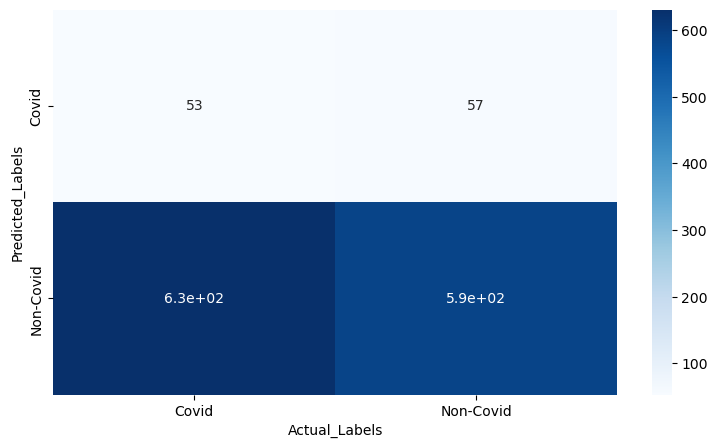

test accuracy = 48.19277108433735%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4819
Precision: 0.4819
Recall: 0.4819
F1 Score: 0.3745


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,X_test_combined,y_test_combined)

In [ ]:
FL_CovidVGG16_model.save('gsm_noniid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 12s 1s/step


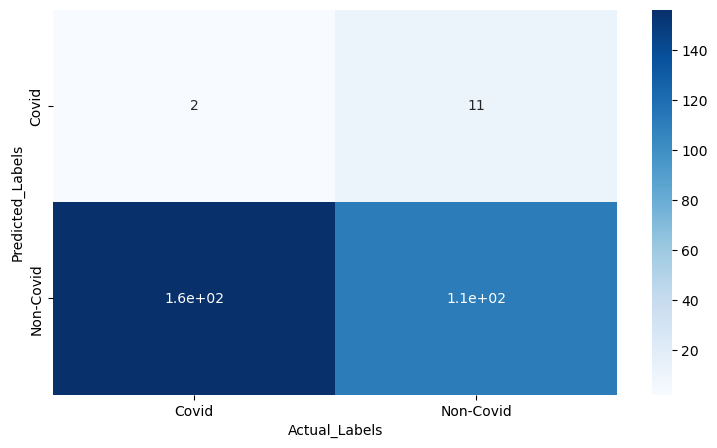

test accuracy = 40.35714285714286%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4036
Precision: 0.268
Recall: 0.4036
F1 Score: 0.2619
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 32s 1s/step


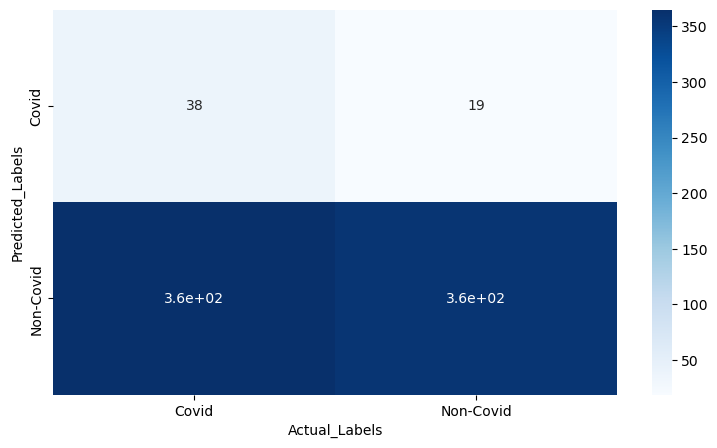

test accuracy = 50.76923076923077%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5077
Precision: 0.5838
Recall: 0.5077
F1 Score: 0.4
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 11s 1s/step


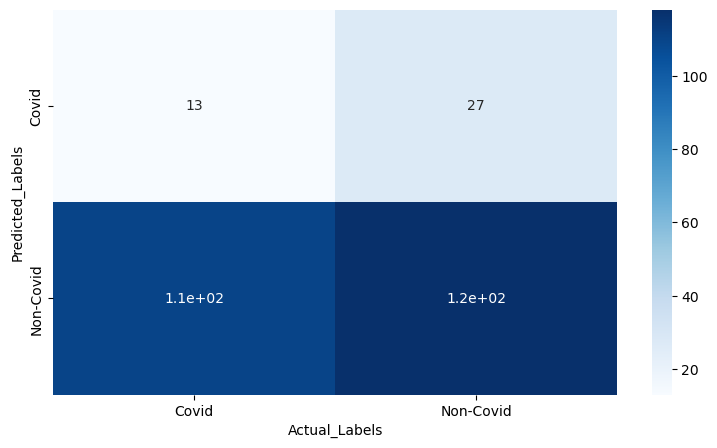

test accuracy = 48.88059701492538%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4888
Precision: 0.4292
Recall: 0.4888
F1 Score: 0.4155


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset3_fed,test_labels_dataset3_fed)

### federated_train_data_nonIID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_balanced)
    FL_CovidVGG16_model = evaluate(server_state,combined_test_data)
    loss = list(FL_CovidVGG16_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidVGG16_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 42s 623ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


  2%|▊                                        | 1/50 [03:29<2:51:04, 209.48s/it]

67/67 [==============================] - 56s 835ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


  4%|█▋                                       | 2/50 [06:43<2:40:07, 200.16s/it]

67/67 [==============================] - 43s 634ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


  6%|██▍                                      | 3/50 [09:17<2:20:15, 179.06s/it]

67/67 [==============================] - 56s 833ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


  8%|███▎                                     | 4/50 [11:59<2:12:13, 172.47s/it]

67/67 [==============================] - 43s 636ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 10%|████                                     | 5/50 [14:48<2:08:19, 171.09s/it]

67/67 [==============================] - 53s 782ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 12%|████▉                                    | 6/50 [17:13<1:58:57, 162.23s/it]

67/67 [==============================] - 46s 668ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 14%|█████▋                                   | 7/50 [20:14<2:00:48, 168.58s/it]

67/67 [==============================] - 25s 366ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 16%|██████▌                                  | 8/50 [22:32<1:51:01, 158.62s/it]

67/67 [==============================] - 56s 836ms/step - loss: 0.6961 - categorical_accuracy: 0.4804


 18%|███████▍                                 | 9/50 [26:06<2:00:13, 175.95s/it]

67/67 [==============================] - 32s 461ms/step - loss: 0.6961 - categorical_accuracy: 0.4812


 20%|████████                                | 10/50 [28:27<1:50:16, 165.42s/it]

67/67 [==============================] - 57s 840ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 22%|████████▊                               | 11/50 [31:31<1:51:07, 170.97s/it]

67/67 [==============================] - 43s 634ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 24%|█████████▌                              | 12/50 [34:05<1:45:06, 165.96s/it]

67/67 [==============================] - 57s 840ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 26%|██████████▍                             | 13/50 [36:45<1:41:04, 163.92s/it]

67/67 [==============================] - 43s 639ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 28%|███████████▏                            | 14/50 [40:14<1:46:32, 177.58s/it]

67/67 [==============================] - 58s 853ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 30%|████████████                            | 15/50 [43:01<1:41:49, 174.56s/it]

67/67 [==============================] - 43s 636ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 32%|████████████▊                           | 16/50 [46:28<1:44:20, 184.14s/it]

67/67 [==============================] - 57s 846ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 34%|█████████████▌                          | 17/50 [49:50<1:44:15, 189.55s/it]

67/67 [==============================] - 43s 633ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 36%|██████████████▍                         | 18/50 [52:24<1:35:25, 178.93s/it]

67/67 [==============================] - 57s 846ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 38%|███████████████▏                        | 19/50 [55:36<1:34:30, 182.92s/it]

67/67 [==============================] - 43s 639ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 40%|████████████████                        | 20/50 [58:15<1:27:52, 175.73s/it]

67/67 [==============================] - 58s 850ms/step - loss: 0.6961 - categorical_accuracy: 0.4827


 42%|███████████████▉                      | 21/50 [1:01:23<1:26:40, 179.32s/it]

67/67 [==============================] - 43s 637ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 44%|████████████████▋                     | 22/50 [1:04:45<1:26:48, 186.02s/it]

67/67 [==============================] - 58s 852ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 46%|█████████████████▍                    | 23/50 [1:07:50<1:23:40, 185.95s/it]

67/67 [==============================] - 43s 635ms/step - loss: 0.6961 - categorical_accuracy: 0.4819


 48%|██████████████████▏                   | 24/50 [1:10:26<1:16:40, 176.95s/it]

67/67 [==============================] - 58s 856ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 50%|███████████████████                   | 25/50 [1:13:35<1:15:10, 180.41s/it]

67/67 [==============================] - 42s 626ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 52%|███████████████████▊                  | 26/50 [1:16:12<1:09:24, 173.51s/it]

67/67 [==============================] - 57s 839ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 54%|████████████████████▌                 | 27/50 [1:18:48<1:04:30, 168.28s/it]

67/67 [==============================] - 43s 632ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 56%|█████████████████████▎                | 28/50 [1:21:42<1:02:20, 170.00s/it]

67/67 [==============================] - 41s 621ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 58%|███████████████████████▏                | 29/50 [1:24:04<56:28, 161.35s/it]

67/67 [==============================] - 51s 755ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 60%|████████████████████████                | 30/50 [1:27:10<56:14, 168.74s/it]

67/67 [==============================] - 30s 441ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 62%|████████████████████████▊               | 31/50 [1:29:30<50:46, 160.32s/it]

67/67 [==============================] - 56s 828ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 64%|█████████████████████████▌              | 32/50 [1:31:35<44:55, 149.75s/it]

67/67 [==============================] - 30s 428ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 66%|██████████████████████████▍             | 33/50 [1:34:21<43:47, 154.57s/it]

67/67 [==============================] - 57s 838ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 68%|███████████████████████████▏            | 34/50 [1:37:57<46:09, 173.08s/it]

67/67 [==============================] - 57s 838ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 70%|████████████████████████████            | 35/50 [1:41:07<44:31, 178.10s/it]

67/67 [==============================] - 57s 843ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 72%|████████████████████████████▊           | 36/50 [1:44:25<42:55, 184.00s/it]

67/67 [==============================] - 56s 832ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 74%|█████████████████████████████▌          | 37/50 [1:46:55<37:37, 173.65s/it]

67/67 [==============================] - 19s 273ms/step - loss: 0.6960 - categorical_accuracy: 0.4812


 76%|██████████████████████████████▍         | 38/50 [1:49:26<33:24, 167.02s/it]

67/67 [==============================] - 57s 843ms/step - loss: 0.6960 - categorical_accuracy: 0.4804


 78%|███████████████████████████████▏        | 39/50 [1:52:00<29:53, 163.01s/it]

67/67 [==============================] - 47s 707ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 80%|████████████████████████████████        | 40/50 [1:55:19<29:00, 174.04s/it]

67/67 [==============================] - 25s 367ms/step - loss: 0.6960 - categorical_accuracy: 0.4819


 82%|████████████████████████████████▊       | 41/50 [1:57:50<25:03, 167.01s/it]

67/67 [==============================] - 58s 851ms/step - loss: 0.6960 - categorical_accuracy: 0.4827


 84%|█████████████████████████████████▌      | 42/50 [2:01:06<23:24, 175.58s/it]

67/67 [==============================] - 57s 840ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 86%|██████████████████████████████████▍     | 43/50 [2:04:01<20:28, 175.45s/it]

67/67 [==============================] - 18s 272ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 88%|███████████████████████████████████▏    | 44/50 [2:05:56<15:43, 157.33s/it]

67/67 [==============================] - 57s 837ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 90%|████████████████████████████████████    | 45/50 [2:08:55<13:38, 163.77s/it]

67/67 [==============================] - 57s 834ms/step - loss: 0.6960 - categorical_accuracy: 0.4842


 92%|████████████████████████████████████▊   | 46/50 [2:11:40<10:56, 164.22s/it]

67/67 [==============================] - 18s 271ms/step - loss: 0.6960 - categorical_accuracy: 0.4842


 94%|█████████████████████████████████████▌  | 47/50 [2:14:05<07:55, 158.41s/it]

67/67 [==============================] - 57s 837ms/step - loss: 0.6960 - categorical_accuracy: 0.4834


 96%|██████████████████████████████████████▍ | 48/50 [2:16:19<05:02, 151.24s/it]

67/67 [==============================] - 29s 430ms/step - loss: 0.6960 - categorical_accuracy: 0.4827


 98%|███████████████████████████████████████▏| 49/50 [2:19:01<02:34, 154.38s/it]

67/67 [==============================] - 56s 832ms/step - loss: 0.6960 - categorical_accuracy: 0.4827


100%|████████████████████████████████████████| 50/50 [2:22:39<00:00, 171.18s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 53s 1s/step


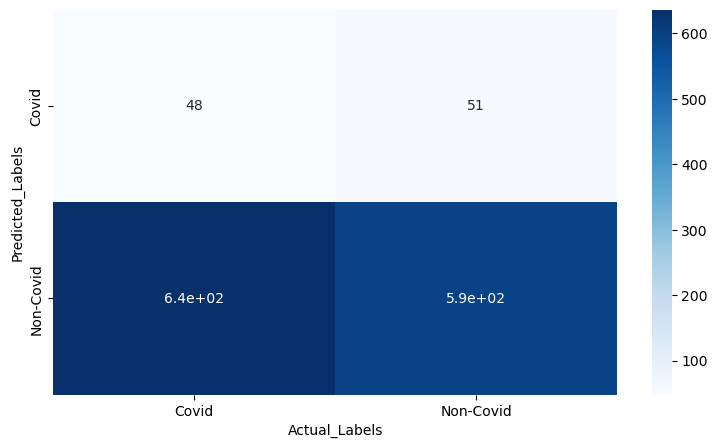

test accuracy = 48.26807228915663%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4827
Precision: 0.4837
Recall: 0.4827
F1 Score: 0.3702


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,X_test_combined,y_test_combined)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 12s 1s/step


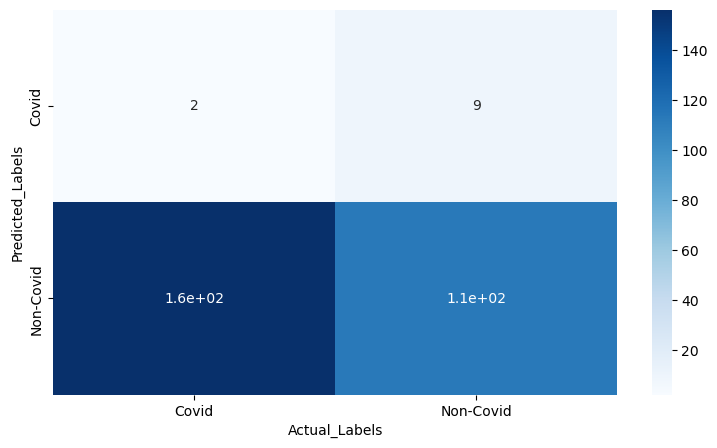

test accuracy = 41.07142857142857%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4107
Precision: 0.2856
Recall: 0.4107
F1 Score: 0.2652
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 31s 1s/step


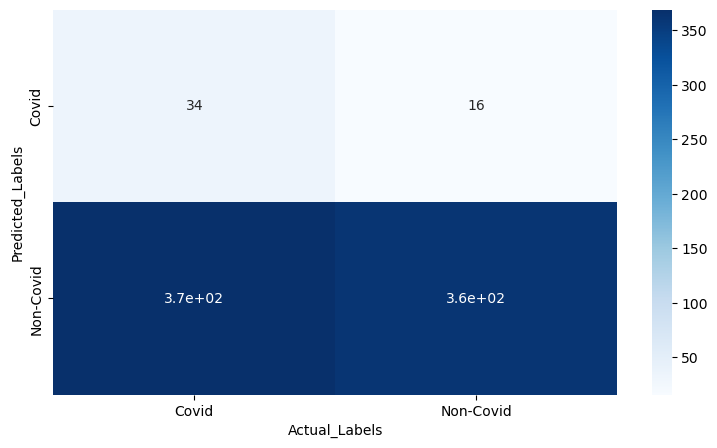

test accuracy = 50.641025641025635%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5064
Precision: 0.5904
Recall: 0.5064
F1 Score: 0.3928
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 11s 1s/step


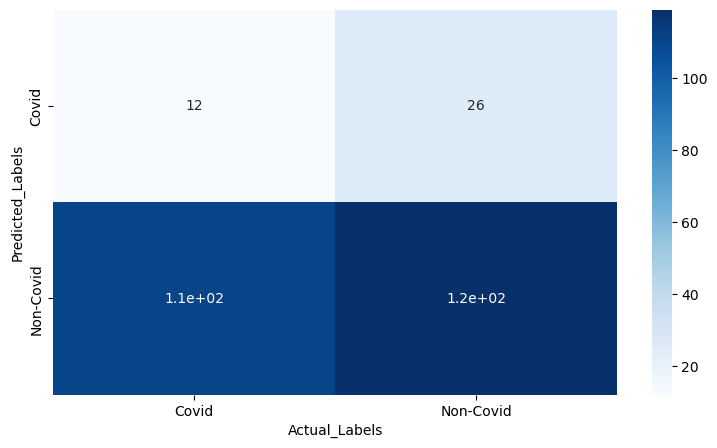

test accuracy = 48.88059701492538%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4888
Precision: 0.4249
Recall: 0.4888
F1 Score: 0.4118


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
FL_CovidVGG16_model.save('gsm_noniid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_unbalanced

In [ ]:
X_test_combined_iid = np.concatenate((test_features_dataset1_fed_iid, test_features_dataset2_fed_iid,
                                  test_features_dataset3_fed_iid), axis=0)
y_test_combined_iid = np.concatenate((test_labels_dataset1_fed_iid, test_labels_dataset2_fed_iid,
                                  test_labels_dataset3_fed_iid), axis=0)
test_data_iid = [(X_test_combined_iid,y_test_combined_iid )]
test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
# test_data_iid = [(X_test_combined_iid,y_test_combined_iid)]
# test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
# combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
# combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_unbalanced)
    FL_CovidVGG16_model = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_CovidVGG16_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidVGG16_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 57s 840ms/step - loss: 0.6950 - categorical_accuracy: 0.4819


  2%|▊                                        | 1/50 [04:15<3:28:58, 255.90s/it]

67/67 [==============================] - 47s 687ms/step - loss: 0.6950 - categorical_accuracy: 0.4819


  4%|█▋                                       | 2/50 [08:34<3:26:13, 257.78s/it]

67/67 [==============================] - 21s 296ms/step - loss: 0.6950 - categorical_accuracy: 0.4827


  6%|██▍                                      | 3/50 [12:35<3:15:50, 250.02s/it]

67/67 [==============================] - 57s 839ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


  8%|███▎                                     | 4/50 [16:45<3:11:29, 249.78s/it]

67/67 [==============================] - 31s 446ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 10%|████                                     | 5/50 [20:53<3:06:49, 249.11s/it]

67/67 [==============================] - 33s 493ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 12%|████▉                                    | 6/50 [25:11<3:05:00, 252.29s/it]

67/67 [==============================] - 56s 846ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 14%|█████▋                                   | 7/50 [29:27<3:01:33, 253.33s/it]

67/67 [==============================] - 57s 841ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 16%|██████▌                                  | 8/50 [34:09<3:03:53, 262.70s/it]

67/67 [==============================] - 58s 853ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 18%|███████▍                                 | 9/50 [38:11<2:55:07, 256.28s/it]

67/67 [==============================] - 57s 835ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 20%|████████                                | 10/50 [42:46<2:54:36, 261.91s/it]

67/67 [==============================] - 37s 546ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 22%|████████▊                               | 11/50 [47:01<2:48:52, 259.80s/it]

67/67 [==============================] - 18s 272ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 24%|█████████▌                              | 12/50 [50:58<2:40:13, 252.98s/it]

67/67 [==============================] - 57s 833ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 26%|██████████▍                             | 13/50 [54:48<2:31:39, 245.95s/it]

67/67 [==============================] - 57s 845ms/step - loss: 0.6949 - categorical_accuracy: 0.4857


 28%|███████████▏                            | 14/50 [58:59<2:28:32, 247.57s/it]

67/67 [==============================] - 41s 600ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 30%|███████████▍                          | 15/50 [1:03:13<2:25:30, 249.45s/it]

67/67 [==============================] - 18s 272ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 32%|████████████▏                         | 16/50 [1:07:11<2:19:23, 245.99s/it]

67/67 [==============================] - 56s 832ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 34%|████████████▉                         | 17/50 [1:11:22<2:16:00, 247.30s/it]

67/67 [==============================] - 49s 725ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 36%|█████████████▋                        | 18/50 [1:15:30<2:12:01, 247.54s/it]

67/67 [==============================] - 58s 848ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 38%|██████████████▍                       | 19/50 [1:18:57<2:01:37, 235.39s/it]

67/67 [==============================] - 57s 844ms/step - loss: 0.6948 - categorical_accuracy: 0.4842


 40%|███████████████▏                      | 20/50 [1:22:56<1:58:18, 236.61s/it]

67/67 [==============================] - 57s 842ms/step - loss: 0.6948 - categorical_accuracy: 0.4842


 42%|███████████████▉                      | 21/50 [1:27:16<1:57:39, 243.44s/it]

67/67 [==============================] - 44s 644ms/step - loss: 0.6948 - categorical_accuracy: 0.4834


 44%|████████████████▋                     | 22/50 [1:31:30<1:55:08, 246.75s/it]

67/67 [==============================] - 58s 853ms/step - loss: 0.6948 - categorical_accuracy: 0.4842


 46%|█████████████████▍                    | 23/50 [1:35:34<1:50:37, 245.83s/it]

67/67 [==============================] - 37s 532ms/step - loss: 0.6948 - categorical_accuracy: 0.4857


 48%|██████████████████▏                   | 24/50 [1:39:47<1:47:28, 248.03s/it]

67/67 [==============================] - 58s 851ms/step - loss: 0.6948 - categorical_accuracy: 0.4857


 50%|███████████████████                   | 25/50 [1:43:30<1:40:14, 240.57s/it]

67/67 [==============================] - 53s 779ms/step - loss: 0.6948 - categorical_accuracy: 0.4857


 52%|███████████████████▊                  | 26/50 [1:47:51<1:38:40, 246.70s/it]

67/67 [==============================] - 24s 343ms/step - loss: 0.6948 - categorical_accuracy: 0.4880


 54%|████████████████████▌                 | 27/50 [1:51:55<1:34:17, 245.99s/it]

67/67 [==============================] - 58s 849ms/step - loss: 0.6948 - categorical_accuracy: 0.4895


 56%|█████████████████████▎                | 28/50 [1:55:40<1:27:50, 239.56s/it]

67/67 [==============================] - 57s 835ms/step - loss: 0.6948 - categorical_accuracy: 0.4902


 58%|██████████████████████                | 29/50 [1:59:45<1:24:28, 241.34s/it]

67/67 [==============================] - 42s 618ms/step - loss: 0.6948 - categorical_accuracy: 0.4902


 60%|██████████████████████▊               | 30/50 [2:04:03<1:22:03, 246.20s/it]

67/67 [==============================] - 26s 387ms/step - loss: 0.6948 - categorical_accuracy: 0.4910


 62%|███████████████████████▌              | 31/50 [2:08:11<1:18:06, 246.64s/it]

67/67 [==============================] - 43s 650ms/step - loss: 0.6948 - categorical_accuracy: 0.4910


 64%|████████████████████████▎             | 32/50 [2:13:05<1:18:17, 260.96s/it]

67/67 [==============================] - 56s 830ms/step - loss: 0.6948 - categorical_accuracy: 0.4910


 66%|█████████████████████████             | 33/50 [2:16:51<1:10:59, 250.58s/it]

67/67 [==============================] - 56s 832ms/step - loss: 0.6948 - categorical_accuracy: 0.4917


 68%|█████████████████████████▊            | 34/50 [2:21:09<1:07:23, 252.75s/it]

67/67 [==============================] - 23s 339ms/step - loss: 0.6948 - categorical_accuracy: 0.4917


 70%|████████████████████████████            | 35/50 [2:24:02<57:11, 228.73s/it]

67/67 [==============================] - 23s 346ms/step - loss: 0.6948 - categorical_accuracy: 0.4925


 72%|████████████████████████████▊           | 36/50 [2:26:12<46:26, 199.05s/it]

67/67 [==============================] - 22s 330ms/step - loss: 0.6947 - categorical_accuracy: 0.4925


 74%|█████████████████████████████▌          | 37/50 [2:28:19<38:26, 177.41s/it]

67/67 [==============================] - 23s 343ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 76%|██████████████████████████████▍         | 38/50 [2:30:27<32:33, 162.77s/it]

67/67 [==============================] - 43s 635ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 78%|███████████████████████████████▏        | 39/50 [2:34:54<35:34, 194.04s/it]

67/67 [==============================] - 28s 409ms/step - loss: 0.6947 - categorical_accuracy: 0.4902


 80%|████████████████████████████████        | 40/50 [2:37:46<31:13, 187.39s/it]

67/67 [==============================] - 44s 643ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


 82%|████████████████████████████████▊       | 41/50 [2:42:12<31:37, 210.83s/it]

67/67 [==============================] - 20s 291ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


 84%|█████████████████████████████████▌      | 42/50 [2:44:29<25:10, 188.79s/it]

67/67 [==============================] - 20s 296ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


 86%|██████████████████████████████████▍     | 43/50 [2:46:28<19:34, 167.81s/it]

67/67 [==============================] - 19s 280ms/step - loss: 0.6947 - categorical_accuracy: 0.4925


 88%|███████████████████████████████████▏    | 44/50 [2:48:25<15:15, 152.60s/it]

67/67 [==============================] - 21s 314ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 90%|████████████████████████████████████    | 45/50 [2:50:24<11:52, 142.50s/it]

67/67 [==============================] - 23s 336ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


 92%|████████████████████████████████████▊   | 46/50 [2:52:33<09:14, 138.54s/it]

67/67 [==============================] - 20s 291ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


 94%|█████████████████████████████████████▌  | 47/50 [2:54:34<06:39, 133.27s/it]

67/67 [==============================] - 23s 339ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 96%|██████████████████████████████████████▍ | 48/50 [2:56:43<04:24, 132.01s/it]

67/67 [==============================] - 19s 277ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


 98%|███████████████████████████████████████▏| 49/50 [2:58:42<02:08, 128.06s/it]

67/67 [==============================] - 19s 285ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


100%|████████████████████████████████████████| 50/50 [3:00:39<00:00, 216.79s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 21s 503ms/step


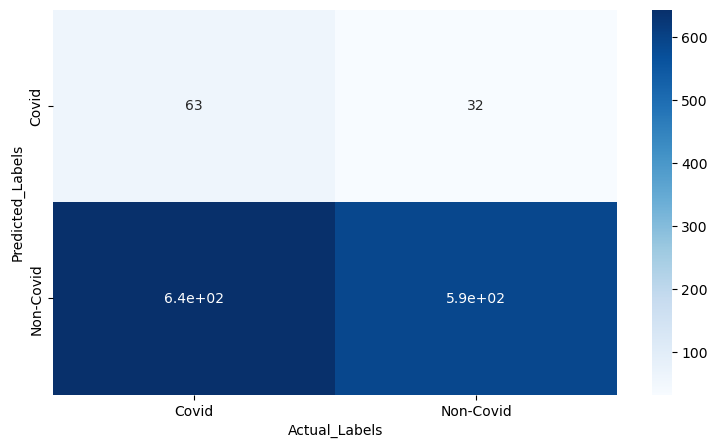

test accuracy = 49.17168674698795%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4917
Precision: 0.5767
Recall: 0.4917
F1 Score: 0.3816


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 4s 462ms/step


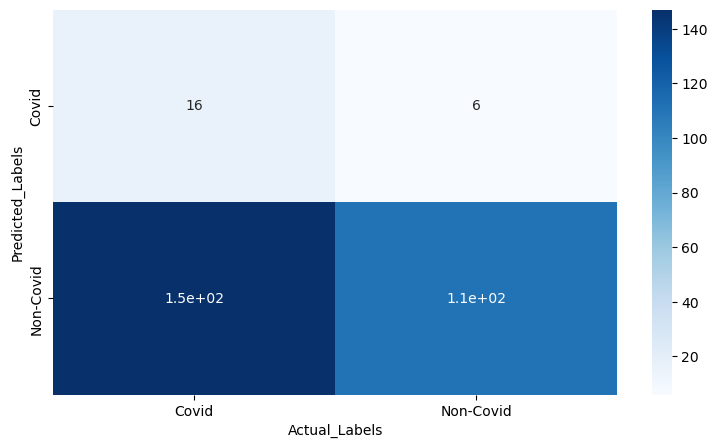

test accuracy = 45.357142857142854%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4536
Precision: 0.6032
Recall: 0.4536
F1 Score: 0.3481
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 12s 468ms/step


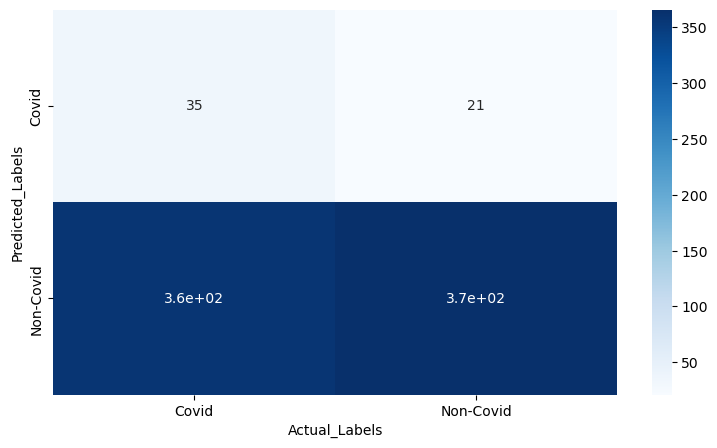

test accuracy = 51.41025641025641%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5141
Precision: 0.5657
Recall: 0.5141
F1 Score: 0.4054
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 4s 449ms/step


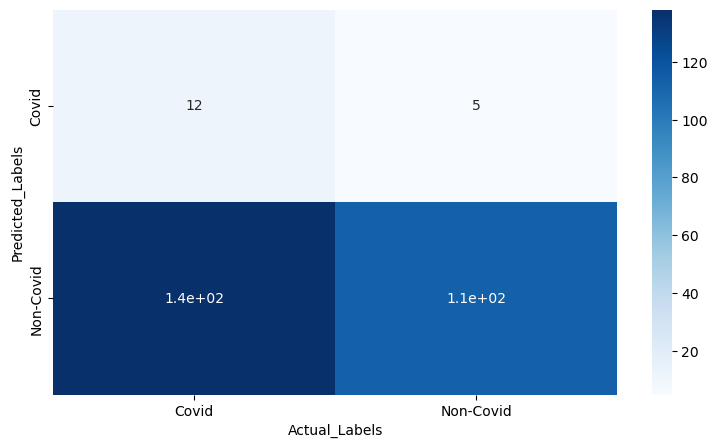

test accuracy = 46.64179104477612%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4664
Precision: 0.5933
Recall: 0.4664
F1 Score: 0.3501


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_CovidVGG16_model.save('gsm_iid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_balanced)
    FL_CovidVGG16_model = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_CovidVGG16_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidVGG16_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 23s 338ms/step - loss: 0.6950 - categorical_accuracy: 0.4819


  2%|▊                                         | 1/50 [01:29<1:12:46, 89.12s/it]

67/67 [==============================] - 22s 326ms/step - loss: 0.6950 - categorical_accuracy: 0.4812


  4%|█▋                                        | 2/50 [02:56<1:10:41, 88.37s/it]

67/67 [==============================] - 18s 273ms/step - loss: 0.6950 - categorical_accuracy: 0.4827


  6%|██▌                                       | 3/50 [04:19<1:07:02, 85.58s/it]

67/67 [==============================] - 18s 273ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


  8%|███▎                                      | 4/50 [05:41<1:04:41, 84.39s/it]

67/67 [==============================] - 18s 273ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 10%|████▏                                     | 5/50 [07:04<1:02:53, 83.87s/it]

67/67 [==============================] - 18s 273ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 12%|█████                                     | 6/50 [08:27<1:01:09, 83.40s/it]

67/67 [==============================] - 19s 285ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 14%|█████▉                                    | 7/50 [09:51<1:00:03, 83.81s/it]

67/67 [==============================] - 22s 332ms/step - loss: 0.6949 - categorical_accuracy: 0.4827


 16%|███████                                     | 8/50 [11:20<59:44, 85.35s/it]

67/67 [==============================] - 22s 332ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 18%|███████▉                                    | 9/50 [12:49<59:02, 86.40s/it]

67/67 [==============================] - 22s 331ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 20%|████████▌                                  | 10/50 [14:17<57:55, 86.88s/it]

67/67 [==============================] - 22s 332ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 22%|█████████▍                                 | 11/50 [15:44<56:38, 87.14s/it]

67/67 [==============================] - 23s 335ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 24%|██████████▎                                | 12/50 [17:13<55:26, 87.53s/it]

67/67 [==============================] - 58s 846ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 26%|██████████▍                             | 13/50 [20:05<1:09:47, 113.18s/it]

67/67 [==============================] - 58s 855ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 28%|███████████▏                            | 14/50 [23:45<1:27:17, 145.49s/it]

67/67 [==============================] - 43s 634ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 30%|████████████                            | 15/50 [26:19<1:26:16, 147.89s/it]

67/67 [==============================] - 42s 627ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 32%|████████████▊                           | 16/50 [28:52<1:24:41, 149.45s/it]

67/67 [==============================] - 58s 859ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 34%|█████████████▌                          | 17/50 [32:04<1:29:13, 162.23s/it]

67/67 [==============================] - 58s 854ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 36%|██████████████▍                         | 18/50 [35:18<1:31:38, 171.83s/it]

67/67 [==============================] - 43s 631ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 38%|███████████████▏                        | 19/50 [37:54<1:26:22, 167.17s/it]

67/67 [==============================] - 42s 625ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 40%|████████████████                        | 20/50 [41:06<1:27:18, 174.62s/it]

67/67 [==============================] - 57s 834ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 42%|████████████████▊                       | 21/50 [44:13<1:26:12, 178.37s/it]

67/67 [==============================] - 57s 838ms/step - loss: 0.6949 - categorical_accuracy: 0.4842


 44%|█████████████████▌                      | 22/50 [47:26<1:25:18, 182.79s/it]

67/67 [==============================] - 43s 631ms/step - loss: 0.6949 - categorical_accuracy: 0.4849


 46%|██████████████████▍                     | 23/50 [50:02<1:18:38, 174.74s/it]

67/67 [==============================] - 43s 633ms/step - loss: 0.6948 - categorical_accuracy: 0.4842


 48%|███████████████████▏                    | 24/50 [52:38<1:13:18, 169.16s/it]

67/67 [==============================] - 58s 853ms/step - loss: 0.6948 - categorical_accuracy: 0.4842


 50%|████████████████████                    | 25/50 [55:26<1:10:14, 168.57s/it]

67/67 [==============================] - 57s 849ms/step - loss: 0.6948 - categorical_accuracy: 0.4834


 52%|████████████████████▊                   | 26/50 [59:05<1:13:31, 183.82s/it]

67/67 [==============================] - 43s 630ms/step - loss: 0.6948 - categorical_accuracy: 0.4834


 54%|████████████████████▌                 | 27/50 [1:01:41<1:07:14, 175.40s/it]

67/67 [==============================] - 42s 623ms/step - loss: 0.6948 - categorical_accuracy: 0.4834


 56%|█████████████████████▎                | 28/50 [1:04:14<1:01:51, 168.68s/it]

67/67 [==============================] - 57s 847ms/step - loss: 0.6948 - categorical_accuracy: 0.4842


 58%|███████████████████████▏                | 29/50 [1:06:54<58:07, 166.09s/it]

67/67 [==============================] - 57s 845ms/step - loss: 0.6948 - categorical_accuracy: 0.4857


 60%|██████████████████████▊               | 30/50 [1:10:31<1:00:29, 181.50s/it]

67/67 [==============================] - 43s 628ms/step - loss: 0.6948 - categorical_accuracy: 0.4857


 62%|████████████████████████▊               | 31/50 [1:13:12<55:27, 175.11s/it]

67/67 [==============================] - 42s 627ms/step - loss: 0.6948 - categorical_accuracy: 0.4857


 64%|█████████████████████████▌              | 32/50 [1:16:23<54:01, 180.07s/it]

67/67 [==============================] - 58s 854ms/step - loss: 0.6948 - categorical_accuracy: 0.4880


 66%|██████████████████████████▍             | 33/50 [1:19:24<51:05, 180.33s/it]

67/67 [==============================] - 58s 849ms/step - loss: 0.6948 - categorical_accuracy: 0.4895


 68%|███████████████████████████▏            | 34/50 [1:22:38<49:10, 184.40s/it]

67/67 [==============================] - 42s 629ms/step - loss: 0.6948 - categorical_accuracy: 0.4902


 70%|████████████████████████████            | 35/50 [1:25:55<47:00, 188.04s/it]

67/67 [==============================] - 30s 442ms/step - loss: 0.6948 - categorical_accuracy: 0.4902


 72%|████████████████████████████▊           | 36/50 [1:28:16<40:38, 174.19s/it]

67/67 [==============================] - 57s 847ms/step - loss: 0.6948 - categorical_accuracy: 0.4902


 74%|█████████████████████████████▌          | 37/50 [1:31:24<38:34, 178.07s/it]

67/67 [==============================] - 58s 849ms/step - loss: 0.6948 - categorical_accuracy: 0.4910


 76%|██████████████████████████████▍         | 38/50 [1:35:03<38:06, 190.53s/it]

67/67 [==============================] - 43s 634ms/step - loss: 0.6948 - categorical_accuracy: 0.4910


 78%|███████████████████████████████▏        | 39/50 [1:37:36<32:51, 179.21s/it]

67/67 [==============================] - 40s 595ms/step - loss: 0.6948 - categorical_accuracy: 0.4910


 80%|████████████████████████████████        | 40/50 [1:40:06<28:25, 170.59s/it]

67/67 [==============================] - 58s 849ms/step - loss: 0.6948 - categorical_accuracy: 0.4917


 82%|████████████████████████████████▊       | 41/50 [1:43:03<25:51, 172.37s/it]

67/67 [==============================] - 58s 853ms/step - loss: 0.6948 - categorical_accuracy: 0.4917


 84%|█████████████████████████████████▌      | 42/50 [1:46:41<24:48, 186.04s/it]

67/67 [==============================] - 43s 629ms/step - loss: 0.6948 - categorical_accuracy: 0.4925


 86%|██████████████████████████████████▍     | 43/50 [1:49:15<20:35, 176.49s/it]

67/67 [==============================] - 42s 622ms/step - loss: 0.6948 - categorical_accuracy: 0.4925


 88%|███████████████████████████████████▏    | 44/50 [1:51:47<16:54, 169.14s/it]

67/67 [==============================] - 58s 852ms/step - loss: 0.6947 - categorical_accuracy: 0.4925


 90%|████████████████████████████████████    | 45/50 [1:54:33<14:01, 168.31s/it]

67/67 [==============================] - 57s 842ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 92%|████████████████████████████████████▊   | 46/50 [1:57:47<11:43, 175.96s/it]

67/67 [==============================] - 43s 632ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 94%|█████████████████████████████████████▌  | 47/50 [2:00:35<08:40, 173.65s/it]

67/67 [==============================] - 43s 633ms/step - loss: 0.6947 - categorical_accuracy: 0.4917


 96%|██████████████████████████████████████▍ | 48/50 [2:03:10<05:35, 167.80s/it]

67/67 [==============================] - 58s 851ms/step - loss: 0.6947 - categorical_accuracy: 0.4902


 98%|███████████████████████████████████████▏| 49/50 [2:06:07<02:50, 170.79s/it]

67/67 [==============================] - 58s 855ms/step - loss: 0.6947 - categorical_accuracy: 0.4910


100%|████████████████████████████████████████| 50/50 [2:09:22<00:00, 155.25s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 54s 1s/step


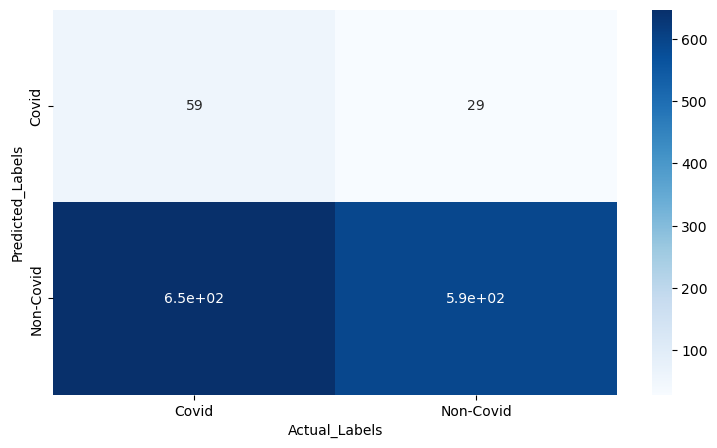

test accuracy = 49.096385542168676%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.491
Precision: 0.5804
Recall: 0.491
F1 Score: 0.3773


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 11s 1s/step


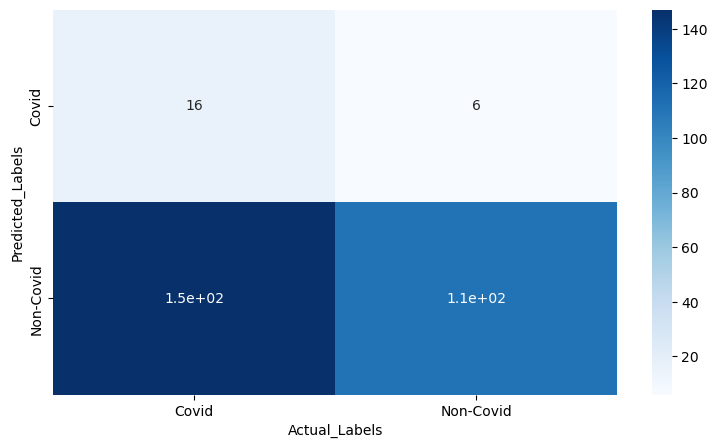

test accuracy = 45.357142857142854%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4536
Precision: 0.6032
Recall: 0.4536
F1 Score: 0.3481
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 29s 1s/step


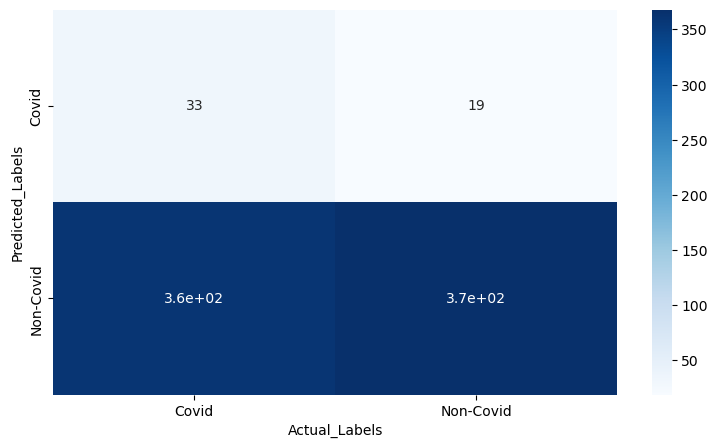

test accuracy = 51.41025641025641%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5141
Precision: 0.5706
Recall: 0.5141
F1 Score: 0.4022
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 8s 890ms/step


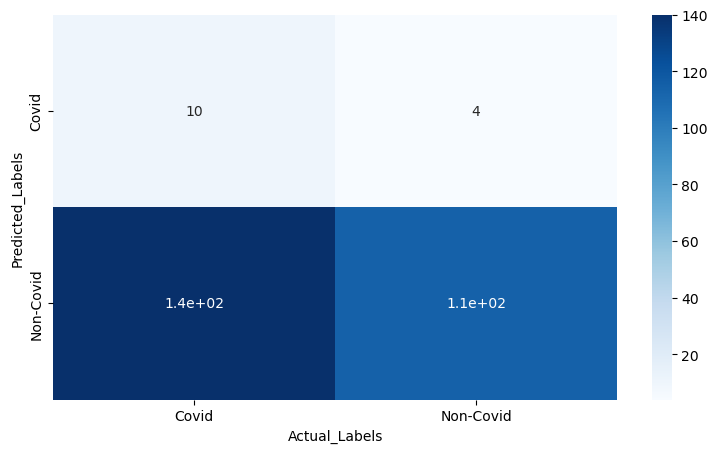

test accuracy = 46.26865671641791%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4627
Precision: 0.5974
Recall: 0.4627
F1 Score: 0.3381


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidVGG16_model,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_CovidVGG16_model.save('gsm_iid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
